# Heart Failure Clinical Records
This notebook will perform some essential EDA and cleaning for the input data.  The data will be exported after it has been cleaned to be used in the model.

## Introduction

The data comes from the [UCL Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#).  It contains medical records of 299 patients who had heart failure and consists of 13 clinical features.  There is also an [academic paper](https://doi.org/10.1186/s12911-020-1023-5) associated with this data, which is in fact based upon an [older paper](https://doi.org/10.1371/journal.pone.0181001).  Both of these papers provide significant detail about what the clinical features mean.  I'm only using their work as a light reference because the challenge of solving this is quite fun on its own.

In this case, the challenge is to predict the `DEATH_EVENT` of a patient as a boolean (in the form of `0` or `1`).  The complete features present in the data are:

* `age` — Age of the patient (years).
* `anaemia` — Decrease of red blood cells or hemoglobin (boolean).
* `high_blood_pressure` — If the patient has hypertension (boolean).
* `creatinine_phosphokinase` — Level of the CPK enzyme in the blood (mcg/L).
* `diabetes` — If the patient has diabetes (boolean).
* `ejection_fraction` — Percentage of blood leaving the heart at each contraction (percentage/100).
* `platelets` — Platelets in the blood (kiloplatelets/mL).
* `sex` — Woman or man (binary).
* `serum_creatinine` — Level of serum creatinine in the blood (mg/dL).
* `serum_sodium` — Level of serum sodium in the blood (mEq/L).
* `smoking` — If the patient smokes or not (boolean).
* `time` — Follow-up period (days).
* `DEATH_EVENT` — If the patient deceased during the follow-up period (boolean).

The newer paper that this data is based upon suggests that using only `ejection_fraction` and `serum_creatinine` can result in an accuracy of ~0.838 (among other measurements).

## Preparation

In [1]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

all_data = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')

## Data Overview
Let's firstly have a browse of the data just to see what is present.

In [2]:
all_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Sanity Checks

Before we continue or make any changes, let's check for any duplicate rows.  Luckily, there are none!

In [3]:
all_data[all_data.duplicated()]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


Let's also check for any missing values that may need to be investigated and fixed (imputing or investigated for removal).  We're lucky again that there are none.

In [4]:
print(f'Total rows with a null element: {sum(all_data.isnull().any(1))}')

Total rows with a null element: 0


## Data Types
So the data has no duplicates or missing values, which is great.  Let's now check the data types for each column based on the accompanying paper's explanation and fix any that come up.

Pandas, by default, uses 64-bit values (`int64`, `float64`, etc.).  We could go about reducing the size of these to save memory, but realistically given the small size of this dataset, it's really not worth doing.

Of the below, the two that concern me are `age` and `platelets`.  The former should definitely be an integer, so something is wrong there.  The latter, looking at the brief dataframe print earlier, could be mostly rounded with a few exceptions; this is worth looking into.

In [5]:
all_data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

### Age
Starting with `age`, we can check what elements are not an integer to see how many are off.

In [6]:
all_data[all_data['age'].map(lambda x: not x.is_integer())]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
185,60.667,1,104,1,30,0,389000.0,1.5,136,1,0,171,1
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172,0


It appears that two values are decimals, so it's likely an input error.  Given that they are so few in number, it's worth just rounding them up and converting the column to be an `int64`.

In [7]:
all_data['age'] = all_data['age'].round(0).astype(np.int64)

In [8]:
print(f'The age column is now: {all_data.age.dtype}')

# Check the above two values that were floats before.
print(f'Entry 185 is now {all_data.age.iloc[185]}')
print(f'Entry 188 is now {all_data.age.iloc[188]}')

The age column is now: int64
Entry 185 is now 61
Entry 188 is now 61


### Platelets
Now let's deal with the `platelets` column.  From my very limited knowledge of platelet measurements, decimal places don't seem to be used.  Let's have a browse of all non-integer values in that column.

In [9]:
float_platelets = all_data[all_data['platelets'].map(lambda x: not x.is_integer())]['platelets']

print(f'Total number of float platelets: {len(float_platelets)}')
print(f'Unique float platelet values: {float_platelets.unique()}')

Total number of float platelets: 25
Unique float platelet values: [263358.03]


Given that the majority of values are integers, that all 25 of the float values are identical, and that the deviation of these float values is *really* close to an integer, it's fairly safe to round and convert just like `age`.  From what I can see, both the old and new paper don't mention this.

In [10]:
all_data['platelets'] = all_data['platelets'].round(0).astype(np.int64)

In [11]:
print(f'The platelets column is now: {all_data.platelets.dtype}')

The platelets column is now: int64


## Data Ranges
The paper that this data comes with describes the ranges within which the data falls.  Let's have a look at the ranges and see if they match.

In [12]:
# Could also do this by hand, but whatever.
all_data.describe().drop(['mean', 'std', '25%', '50%', '75%'])

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0
min,40.0,0.0,23.0,0.0,14.0,0.0,25100.0,0.5,113.0,0.0,0.0,4.0,0.0
max,95.0,1.0,7861.0,1.0,80.0,1.0,850000.0,9.4,148.0,1.0,1.0,285.0,1.0


Of these, `serum_sodium` is listed as having a minimum of `114`, but here it's `113`.  I cannot see this being an issue and it's likely a misreporting, so I'll leave that unchanged.

They have also converted `platelets` by multiplying it by `0.001`, likely to either have the units in a different scale or to bring it closer to the other variables.  Regardless, I'll do the same.

In [13]:
all_data['platelets'] = all_data['platelets'] * 0.001

## Skewness
Since many outlier detection algorithms are susceptible to skewed datasets, let's firstly see if any of the data needs to be transformed due to being too skewed.  Typically, anything within `+/- 0.5` is acceptable, up to `+/- 1.0` is moderately skewed, and anything over `+/- 1.0` is highly skewed.  We can view these with histograms or by calculating the skew.

Any transformations made here will have to be made to new input data to the machine learning model too.

Let's begin by identifying any columns that are a little too high.

In [14]:
# Arbitrarily chosen. Medium skewness is worth investigating.
skew_threshold = 0.5

# Compute the skewness for all columns except the target and any known booleans.
skew_drop = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking', 'DEATH_EVENT']
skewed_df = all_data.drop(skew_drop, axis=1).skew().sort_values(ascending=False)
skewed_df = skewed_df[(skewed_df > skew_threshold) | (skewed_df < -skew_threshold)]
skewed_df

creatinine_phosphokinase    4.463110
serum_creatinine            4.455996
platelets                   1.462321
ejection_fraction           0.555383
serum_sodium               -1.048136
dtype: float64

There are a few listed above, so let's view them, scale them with a `log`, and then view them again.  Originally I had used `boxcox` here, but it was problematic with `serum_sodium`, returning a very large lambda, so I've reverted to `log` just to be safe.

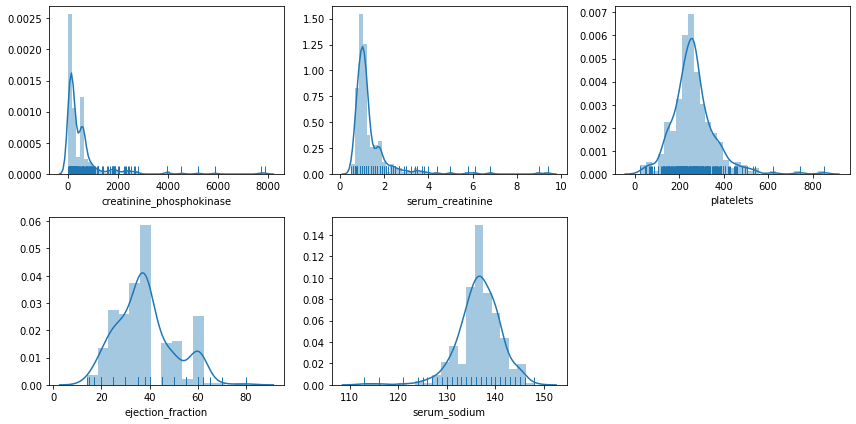

In [15]:
skew_fig = plt.figure(figsize=(12,6))
for i in range(1, len(skewed_df)+1):
    skew_fig.add_subplot(2, 3, i)
    col = skewed_df.index[i-1]
    sns.distplot(all_data[col], rug=True)
skew_fig.tight_layout()
plt.show()

In [16]:
# Log all of the skewed columns in the original dataset.
for col in skewed_df.index:
    all_data[col] = np.log(all_data[col])
    #all_data[col] = stats.boxcox(all_data[col])[0]

Now that the columns have been unskewed, the skewness looks much better!

In [17]:
for col in skewed_df.index:
    skew_val = all_data[col].skew()
    print(f'{col} skew: {skew_val}')

creatinine_phosphokinase skew: 0.41400698865657504
serum_creatinine skew: 1.583989782127556
platelets skew: -1.2849539031426445
ejection_fraction skew: -0.27210475252918837
serum_sodium skew: -1.3122653778551319


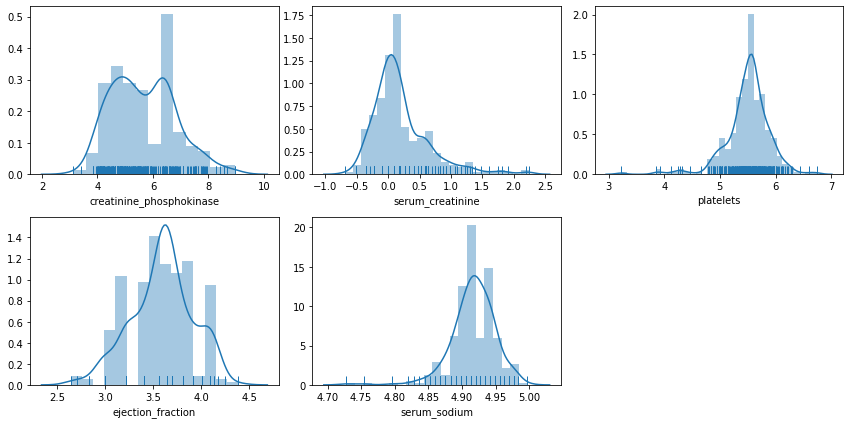

In [18]:
skew_fig = plt.figure(figsize=(12,6))
for i in range(1, len(skewed_df)+1):
    skew_fig.add_subplot(2, 3, i)
    col = skewed_df.index[i-1]
    sns.distplot(all_data[col], rug=True)
skew_fig.tight_layout()
plt.show()

## Outliers
Now that the data has been normalized better, we can more accurately detect and process outliers.  We could use a Cook's score here, z-score, or even more advanced methods like clustering with DBSCAN, but I'm going to stick with IQR and I've had good results with it in the past.

Treating outliers is always a prickly subject.  We could do nothing, treat them as missing and impute them based on similar values, winsorize them by replacing them with boundary values, remove them completely, and more.  We must also consider that the dataset we have is relatively small, so what we see as outliers may very well be normal in a larger dataset.

I tend to firstly look to see if it's obviously a measurement error or data entry error; something that is clearly incorrect.  If that's not the case, then I see how far away that value really is, and whether it's isolated or within a group.  I usually then test the outliers against the target variable, as the very fact that they are "outliers" may strongly contribute to the outcome!

In [19]:
def outliers_for_column(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    return df[(df[col] > upper) | (df[col] < lower)]

In [20]:
for col in all_data.columns:
    outliers = outliers_for_column(all_data, col)
    if len(outliers) > 0:
        print(f'{col} has {len(outliers)} outliers.')

creatinine_phosphokinase has 2 outliers.
ejection_fraction has 3 outliers.
platelets has 16 outliers.
serum_creatinine has 17 outliers.
serum_sodium has 5 outliers.


Below I'm making a helper function to investigate the outliers.  It has five sections.

1. Get all of the outliers.
2. Calculate deaths in the outliers relative to their own length and also in respect to the global count.
3. See how far the outliers sit from the min/mean/max of the data *without* the outliers present.
4. Show the outliers' complete row information for inspection.
5. Show a boxplot of the original column split by the target variable.

These used together can help to decide what to do with the outliers.  One thing to consider here, especially given the limited size of the dataset, is that outliers very well may be a contributing factor for death, and that removing them would significantly reduce the number of deaths, creating a very imbalanced dataset.

In [21]:
# Helper function for investigating the outliers.
def investigate_outliers(df, col):
    all_data_len = len(all_data)
    all_data_deaths = sum(all_data['DEATH_EVENT'] == 1)
    
    print(f'{col}:')
    
    # 1. Get all outliers for the column.
    outliers = outliers_for_column(all_data, col)
    num_outs = len(outliers)
    total_pct = round((num_outs / all_data_len)*100, 2)
    print(f'  {num_outs}/{all_data_len} total samples are outliers ({total_pct}%)')
    
    # 2. How many deaths were a result of the outliers and what percentage is this of the column?
    outlier_deaths = outliers[outliers['DEATH_EVENT'] == 1]
    num_out_deaths = len(outlier_deaths)
    out_death_pct = round((num_out_deaths / num_outs)*100, 2)
    out_death_pct_global = round((num_out_deaths / all_data_deaths)*100, 2)
    print(f'  {num_out_deaths}/{num_outs} deaths within the outliers ({out_death_pct}%)')
    print(f'  {num_out_deaths}/{all_data_deaths} global deaths are from the outliers ({out_death_pct_global}%)')

    # 3. How far from the min/max/mean are the outliers?
    df_outs_removed = all_data.drop(outliers.index)[col]
    removed_min = df_outs_removed.min()
    removed_mean = df_outs_removed.mean()
    removed_max = df_outs_removed.max()
    print(f'\nWith outliers removed, {col} has ', end='')
    print(f'(min={round(removed_min, 2)})', end='')
    print(f' (mean={round(removed_mean, 2)})', end='')
    print(f' (max: {round(removed_max, 2)}).')
    print('Outliers and their distance from the removed mean:')
    for idx,row in outliers.iterrows():
        print(f'  [{idx}] is ~{round(abs(removed_mean - row[col]), 2)} from the removed mean.')
    
    # 4. Show the outliers table.
    print('\nRaw data points:')
    display(HTML(outliers.to_html()))
    
    # 5. Show the (non-removed) boxplot for eyeballing outliers, split by DEATH_EVENT.
    print(f'\n{col} boxplot:')
    sns.boxplot(x=all_data[col], y=all_data['DEATH_EVENT'], orient='h')

### `creatinine_phosphokinase`
Let's begin with `creatinine_phosphokinase`.  The two outliers are both responsible for deaths but only make up ~2% of the total death count.  Their actual value does not differ too much from the maximum of the removed mean.  I do not see any reason to remove or alter them based on their values unless they become problematic later.

creatinine_phosphokinase:
  2/299 total samples are outliers (0.67%)
  2/2 deaths within the outliers (100.0%)
  2/96 global deaths are from the outliers (2.08%)

With outliers removed, creatinine_phosphokinase has (min=3.14) (mean=5.64) (max: 8.68).
Outliers and their distance from the removed mean:
  [1] is ~3.33 from the removed mean.
  [60] is ~3.31 from the removed mean.

Raw data points:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
1,55,0,8.969669,0,3.637586,0,5.573514,0.09531,4.912655,1,0,6,1
60,45,0,8.949235,1,3.218876,1,5.966147,0.00000,4.934474,1,0,60,1



creatinine_phosphokinase boxplot:


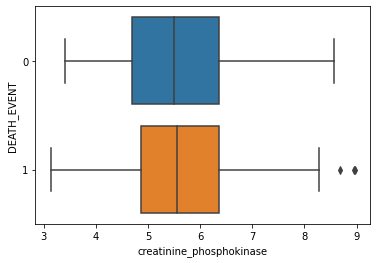

In [22]:
investigate_outliers(all_data, 'creatinine_phosphokinase')

### `ejection_fraction`
A very similar situation from the previous variable.  The points are few in number and do not deviate too much.  However, this time all three *did not* die.

ejection_fraction:
  3/299 total samples are outliers (1.0%)
  3/3 deaths within the outliers (100.0%)
  3/96 global deaths are from the outliers (3.12%)

With outliers removed, ejection_fraction has (min=2.83) (mean=3.6) (max: 4.38).
Outliers and their distance from the removed mean:
  [6] is ~0.89 from the removed mean.
  [17] is ~0.96 from the removed mean.
  [66] is ~0.89 from the removed mean.

Raw data points:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
6,75,1,5.505332,0,2.708050,0,4.844187,0.182322,4.919981,1,0,10,1
17,45,0,6.366470,0,2.639057,0,5.111988,-0.223144,4.844187,1,0,14,1
66,42,1,5.521461,1,2.708050,0,5.361292,0.262364,4.912655,0,0,65,1



ejection_fraction boxplot:


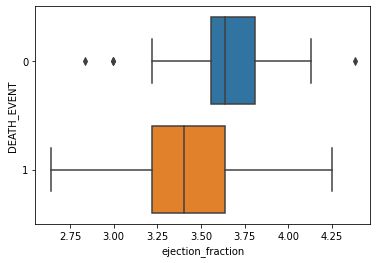

In [23]:
investigate_outliers(all_data, 'ejection_fraction')

### `platelets`
The outliers here are a little different.  Firstly they are greater in number, almost evenly spread between death and survival, and contribute to a greater number of deaths on the global scale.  Again, though, they do not deviate too far from the removed mean, so I'm not too worried about them yet.  There does seem to be a bias toward the lower bound for outliers which could warrant more investigation in the future.

platelets:
  16/299 total samples are outliers (5.35%)
  7/16 deaths within the outliers (43.75%)
  7/96 global deaths are from the outliers (7.29%)

With outliers removed, platelets has (min=4.84) (mean=5.53) (max: 6.23).
Outliers and their distance from the removed mean:
  [15] is ~1.68 from the removed mean.
  [19] is ~1.07 from the removed mean.
  [65] is ~0.76 from the removed mean.
  [71] is ~0.73 from the removed mean.
  [105] is ~0.9 from the removed mean.
  [109] is ~1.21 from the removed mean.
  [163] is ~1.22 from the removed mean.
  [167] is ~1.29 from the removed mean.
  [176] is ~0.88 from the removed mean.
  [200] is ~1.24 from the removed mean.
  [230] is ~1.41 from the removed mean.
  [240] is ~0.74 from the removed mean.
  [277] is ~2.31 from the removed mean.
  [281] is ~1.6 from the removed mean.
  [287] is ~0.76 from the removed mean.
  [296] is ~1.08 from the removed mean.

Raw data points:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
15,82,1,5.937536,0,3.912023,0,3.850148,0.262364,4.912655,1,0,13,1
19,48,1,6.366470,1,4.007333,0,4.465908,0.641854,4.795791,0,0,15,1
65,60,0,4.219508,0,2.995732,0,4.779123,1.064711,4.844187,1,1,64,1
71,58,0,6.366470,1,3.555348,0,4.804021,-0.105361,4.934474,1,1,71,0
105,72,1,5.793014,0,3.401197,1,6.431331,0.530628,4.927254,0,1,88,1
109,45,0,5.676754,1,3.555348,0,6.745236,0.262364,4.955827,1,1,88,0
163,50,1,7.755339,1,3.555348,0,4.317488,-0.105361,4.955827,0,0,126,1
167,59,0,4.189655,1,2.995732,0,4.248495,0.875469,4.897840,1,0,135,1
176,69,0,7.257708,0,3.688879,0,4.653960,0.000000,4.905275,1,1,147,0
200,63,1,7.477038,0,3.806662,0,4.290459,-0.356675,4.919981,1,0,186,0



platelets boxplot:


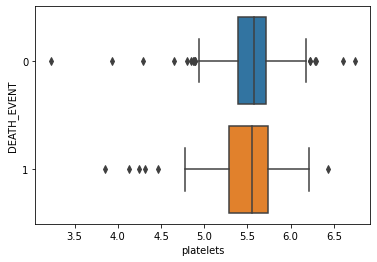

In [24]:
investigate_outliers(all_data, 'platelets')

### `serum_creatinine`
This is almost the same story as `platelets` except that the deaths are greater in number and the tend is toward the upper bound instead of the lower bound.  Again, deviation is quite low.

serum_creatinine:
  17/299 total samples are outliers (5.69%)
  11/17 deaths within the outliers (64.71%)
  11/96 global deaths are from the outliers (11.46%)

With outliers removed, serum_creatinine has (min=-0.69) (mean=0.12) (max: 0.99).
Outliers and their distance from the removed mean:
  [9] is ~2.12 from the removed mean.
  [10] is ~1.27 from the removed mean.
  [28] is ~1.64 from the removed mean.
  [31] is ~0.98 from the removed mean.
  [35] is ~1.13 from the removed mean.
  [39] is ~0.98 from the removed mean.
  [48] is ~1.36 from the removed mean.
  [52] is ~1.8 from the removed mean.
  [65] is ~0.94 from the removed mean.
  [117] is ~1.04 from the removed mean.
  [124] is ~1.19 from the removed mean.
  [129] is ~1.1 from the removed mean.
  [131] is ~1.69 from the removed mean.
  [203] is ~1.13 from the removed mean.
  [217] is ~2.08 from the removed mean.
  [228] is ~1.49 from the removed mean.
  [282] is ~1.21 from the removed mean.

Raw data points:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
9,80,1,4.812184,0,3.555348,1,5.961005,2.240710,4.890349,1,1,10,1
10,75,1,4.394449,0,3.637586,1,5.908083,1.386294,4.875197,1,1,10,1
28,58,1,4.094345,0,3.637586,0,5.030438,1.757858,4.897840,1,0,26,1
31,85,0,3.135494,0,3.806662,0,5.886104,1.098612,4.882802,1,0,28,1
35,69,0,6.366470,1,3.555348,0,5.429346,1.252763,4.897840,1,0,30,1
39,60,0,5.459586,1,3.637586,0,5.796058,1.098612,4.955827,0,0,30,1
48,80,1,6.315358,0,2.995732,1,4.941642,1.481605,4.890349,1,0,41,1
52,60,0,8.285009,1,4.127134,0,5.573514,1.916923,4.983607,0,0,43,1
65,60,0,4.219508,0,2.995732,0,4.779123,1.064711,4.844187,1,1,64,1
117,85,1,4.624973,0,4.094345,0,6.228511,1.163151,4.927254,0,0,94,0



serum_creatinine boxplot:


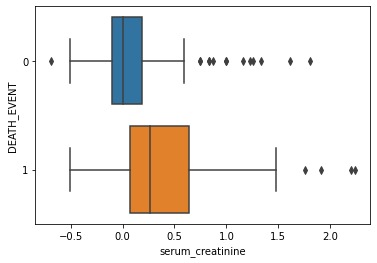

In [25]:
investigate_outliers(all_data, 'serum_creatinine')

### `serum_sodium`
As with the first two sets of outliers, they contribute a little to the global score and do not deviate much.

serum_sodium:
  5/299 total samples are outliers (1.67%)
  3/5 deaths within the outliers (60.0%)
  3/96 global deaths are from the outliers (3.12%)

With outliers removed, serum_sodium has (min=4.84) (mean=4.92) (max: 5.0).
Outliers and their distance from the removed mean:
  [4] is ~0.17 from the removed mean.
  [19] is ~0.12 from the removed mean.
  [126] is ~0.1 from the removed mean.
  [199] is ~0.19 from the removed mean.
  [225] is ~0.09 from the removed mean.

Raw data points:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
4,65,1,5.075174,1,2.995732,0,5.789960,0.993252,4.753590,0,0,8,1
19,48,1,6.366470,1,4.007333,0,4.465908,0.641854,4.795791,0,0,15,1
126,46,0,5.123964,1,2.833213,1,5.602119,0.741937,4.820282,0,0,100,1
199,60,0,7.099202,1,3.555348,0,5.573514,0.587787,4.727388,1,1,186,0
225,75,0,6.514713,1,4.094345,0,5.579730,0.336472,4.828314,0,0,205,0



serum_sodium boxplot:


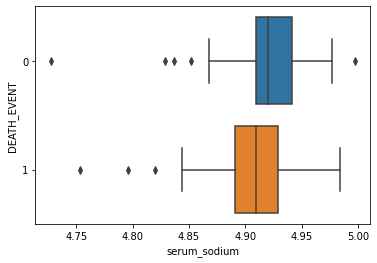

In [26]:
investigate_outliers(all_data, 'serum_sodium')

Overall, especially with a larger dataset, all of these outliers could be considered in more detail.  I'd have to also research the individual medical concepts in more detail to have a better judgment too.

Given the small sample size, it is difficult to determine if they are truly erroneous or genuine variation that humans are able to experience with a lower probability.

## Target Variable Impact

### `DEATH_EVENT` Balance
A total of ~32% of the samples resulted in death.  That's almost a 30/70 split, which isn't *terrible* but definitely isn't great.  The best option here is to use some kind of resampling method, but that would be in our machine learning script, not in the EDA.  Since the data isn't horribly unbalanced (like in fraud detection), I'll likely leave it at first and consider it later.

In [27]:
total_deaths = sum(all_data['DEATH_EVENT'] == 1)
total_deaths_pct = round((total_deaths / len(all_data))*100, 2)
print(f'{total_deaths}/{len(all_data)} samples died ({total_deaths_pct}%).')

96/299 samples died (32.11%).


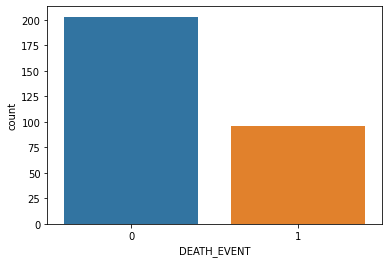

In [28]:
sns.countplot(data=all_data, x='DEATH_EVENT')
plt.show()

### Feature Selection
Before wrapping up the EDA, I want to choose what variables could be used in the machine learning model.  There are many ways to do this, but generally speaking, we want to keep the model simple, ensure the input data is of quality, and generally keep dimensionality low (which helps to avoid overfitting).

#### Version 1: Recursive Feature Elimination
Firstly trying the more advanced method of using a model to recursively disregard features and retain only the important ones.  This code is partially lifted from the [official docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

This resulted in `ejection_fraction`, `serum_creatinine`, and `time` being selected.  The paper mentions how they disregarded `time` as they wanted to focus on clinical features, and that they show the correlation, while present, is an impossibility in regard to the target feature, so we can ignore it.

In [29]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

X = all_data.drop('DEATH_EVENT', axis=1)
y = all_data['DEATH_EVENT']

# Normalize the data before running it through a model.
scaler = StandardScaler()
X_norm = scaler.fit_transform(X, y)

# Recursively get the 'best features'.
num_features = 3 # Arbitrarily chosen.
rfe = RFE(SVR(kernel='linear'), n_features_to_select=num_features, step=1)
rfe.fit(X_norm, y)

print(f'The top {num_features} are ', end='')
print(', '.join(X.loc[:, rfe.support_].columns))

The top 3 are ejection_fraction, serum_creatinine, time


#### Version 2: Pearson's Correlation
My personal favorite (colorful graphs!) is using Pearson's correlation of predictors against the target variable and then extracting the highest values.

Looking at this lovely chart, `time` is up there at the top, followed by `serum_creatinine`, `ejection_fraction`, and `age` if we add one more.  This is in line with the RFE method, so that's good news!

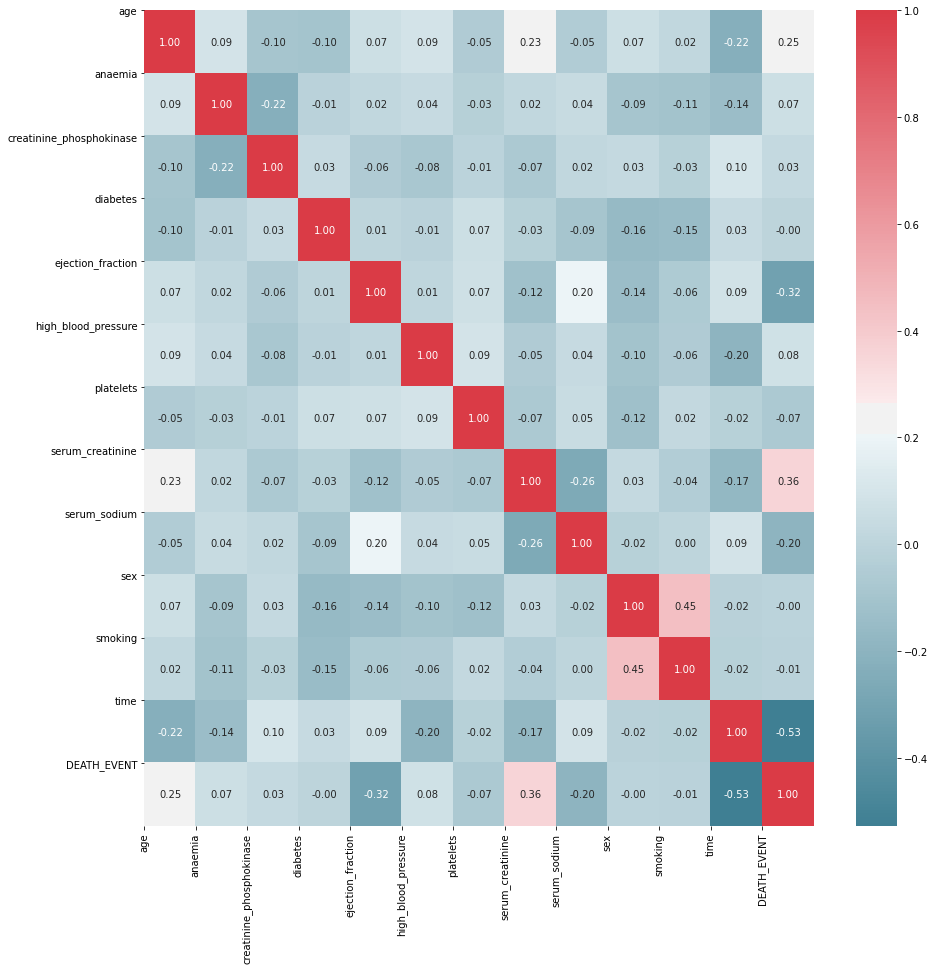

In [30]:
corr = all_data.corr()
fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

### Selected Predictors vs. Target
The selected variables are `serum_creatinine` and `ejection_fraction`.

In [31]:
def investigate_vs_target(df, col):
    print(f'Statistics for {col}:')
    df_survived = df[df['DEATH_EVENT']==0][col]
    df_died = df[df['DEATH_EVENT']==1][col]
    stat = pd.DataFrame({
        'survived': df_survived.describe(),
        'died': df_died.describe()
    })
    display(HTML(stat.to_html()))
    
    sns.stripplot(data=df, x='DEATH_EVENT', y=col)
    plt.show()

Looking at `serum_creatinine`, it appears that those that died tended toward higher values, and those that survived are generally grouped toward the bottom.  There are outliers in those that survived that rival the higher levels found in those who died, but this is expected and demonstrates that this value alone isn't responsible but contributes to the chance of death.

Based on my *very* limited knowledge of this subject (basically from the papers and Googling), high values are bad.  As the paper states, *if a patient has high levels of serum creatinine, it may indicate renal dysfunction*, which isn't something that's desirable.  

Statistics for serum_creatinine:


,survived,died
count,203.000000,96.000000
mean,0.086507,0.435589
std,0.364838,0.526672
min,-0.693147,-0.510826
25%,-0.105361,0.071483
50%,0.000000,0.262364
75%,0.182322,0.641854
max,1.808289,2.240710


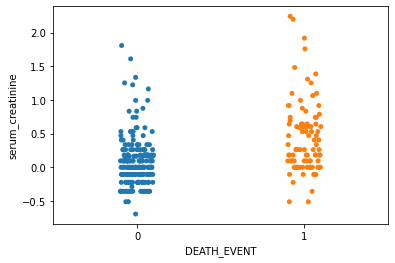

In [32]:
investigate_vs_target(all_data, 'serum_creatinine')

There's a similar story with `ejection_fraction`.  This represents the *percentage of blood leaving the heart at each contraction*.  Naturally, you don't want this to be low.  While the values tend to be quite similar for those who died and those who survived, there is a general tendency for those who died toward lower values, which is obviously not good news.

Statistics for ejection_fraction:


,survived,died
count,203.000000,96.000000
mean,3.660287,3.443983
std,0.266302,0.366672
min,2.833213,2.639057
25%,3.555348,3.218876
50%,3.637586,3.401197
75%,3.806662,3.637586
max,4.382027,4.248495


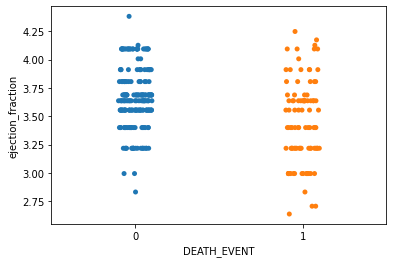

In [33]:
investigate_vs_target(all_data, 'ejection_fraction')

## Export Data
With all of this done, let's export to CSV!

As a reminder, we have:

* Changed the datatypes of and rounded `age` and `platelets`.
* Applied a `np.log` to `creatinine_phosphokinase`, `serum_creatinine`, `platelets`, `ejection_fraction`, and `serum_sodium`.

In [34]:
all_data.to_csv('./data/cleaned.csv', index=False)